# Downstream analysis 1: Factor-specific analyses

This tutorial is focused on using the loadings obtained with Tensor-cell2cell for each element in their respective dimensions of the 4D-communication tensor (contexts, ligand-receptor pairs, sender cells, receiver cells). These loadings give the importance of each element in the each of the factors obtained with Tensor-cell2cell. Thus, one can gain more insights of what biological processes are involved in each of the communication patterns.

In [1]:
import cell2cell as c2c
import scanpy as sc

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1 - Load Data

**Specify folders where the data is located, and where the outputs will be written:**

In [3]:
import os

data_folder = './'
directory = os.fsencode(data_folder)

output_folder = './results/'
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

**Open the loadings obtained from the tensor factorization**

In [4]:
factors = c2c.io.load_tensor_factors('./results/Loadings.xlsx')

**Dictionary with the condition of each sample/context**

This was generated when preprocessing the data in the Tensor Factorization notebook.

In [5]:
context_dict = {'5144_PFC': 'ASD',
               '5278_PFC': 'ASD',
               '5294_BA9': 'ASD',
               '5403_PFC': 'ASD',
               '5419_PFC': 'ASD',
               '5531_BA9': 'ASD',
               '5565_BA9': 'ASD',
               '5841_BA9': 'ASD',
               '5864_BA9': 'ASD',
               '5939_BA9': 'ASD',
               '5945_PFC': 'ASD',
               '5978_BA9': 'ASD',
               '6033_BA9': 'ASD',
               '4341_BA46': 'Control',
               '5387_BA9': 'Control',
               '5408_PFC_Nova': 'Control',
               '5538_PFC_Nova': 'Control',
               '5577_BA9': 'Control',
               '5879_PFC_Nova': 'Control',
               '5893_PFC': 'Control',
               '5936_PFC_Nova': 'Control',
               '5958_BA9': 'Control',
               '5976_BA9': 'Control'}

## 2 - Downstream Analyses

### Boxplots to compare group of samples/contexts

The statistical test and the multiple test correction can be changed by modifying the parameters

```statistical_test='t-test_ind'```

```pval_correction='bonferroni'```

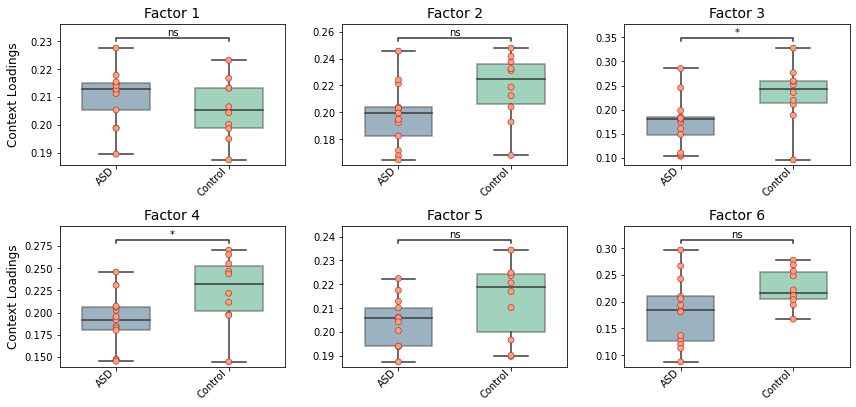

In [6]:
boxplot = c2c.plotting.factor_plot.context_boxplot(factors['Contexts'],
                                                   metadict=context_dict,
                                                   nrows=2,
                                                   figsize=(12, 6),
                                                   group_order=['ASD', 'Control'],
                                                   statistical_test='t-test_ind',
                                                   pval_correction='bonferroni',
                                                   cmap='viridis',
                                                   verbose=False,
                                                   filename=output_folder + 'Sample-Boxplots.svg'
                                                  )

From this analysis, the communication patterns identified in Factor 3 and Factor 4 are statistically significantly different between ASD and Control patients. In contrast, the remaining factors are not varying in a context-dependent manner, indicating that the differences in communication here are due to differences in the LR-pairs as well as cell types participating in communication.

### Generate factor-specific networks

**Adjacency matrices of the CCC networks for each of the factors can be obtained:**

In [7]:
networks = c2c.analysis.tensor_downstream.get_factor_specific_ccc_networks(factors, 
                                                                           sender_label='Sender Cells',
                                                                           receiver_label='Receiver Cells')

**Generate matrix of cell-cell pairs by factors**

Here we convert the adjacency matrices into matrices where columns are
the directed cell-cell pairs and rows the factors.

In [8]:
network_by_factors = c2c.analysis.tensor_downstream.flatten_factor_ccc_networks(networks, orderby='receivers')

**Select cell-cell pairs with high potential of interaction**

y using the previous matrix, we can see the distribution of CCC potential. Then we can set a threshold to define communication occurring with high potential.

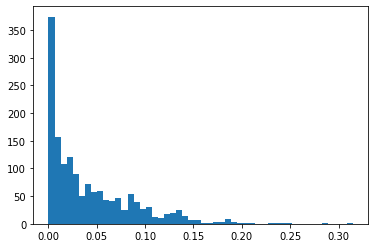

In [9]:
_ = plt.hist(network_by_factors.values.flatten(), bins = 50)

**Here we set a threshold of 0.075**

In [10]:
# To consider only cells with high potential to interact in each factor
ccc_threshold = 0.075

**We can visualize networks of factors with significant differences between groups**

As shown in the boxplot, ASD vs Control are significantly different in factors 3 and 4

(<Figure size 2304x1152 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe8dad7e4d0>,
       dtype=object))

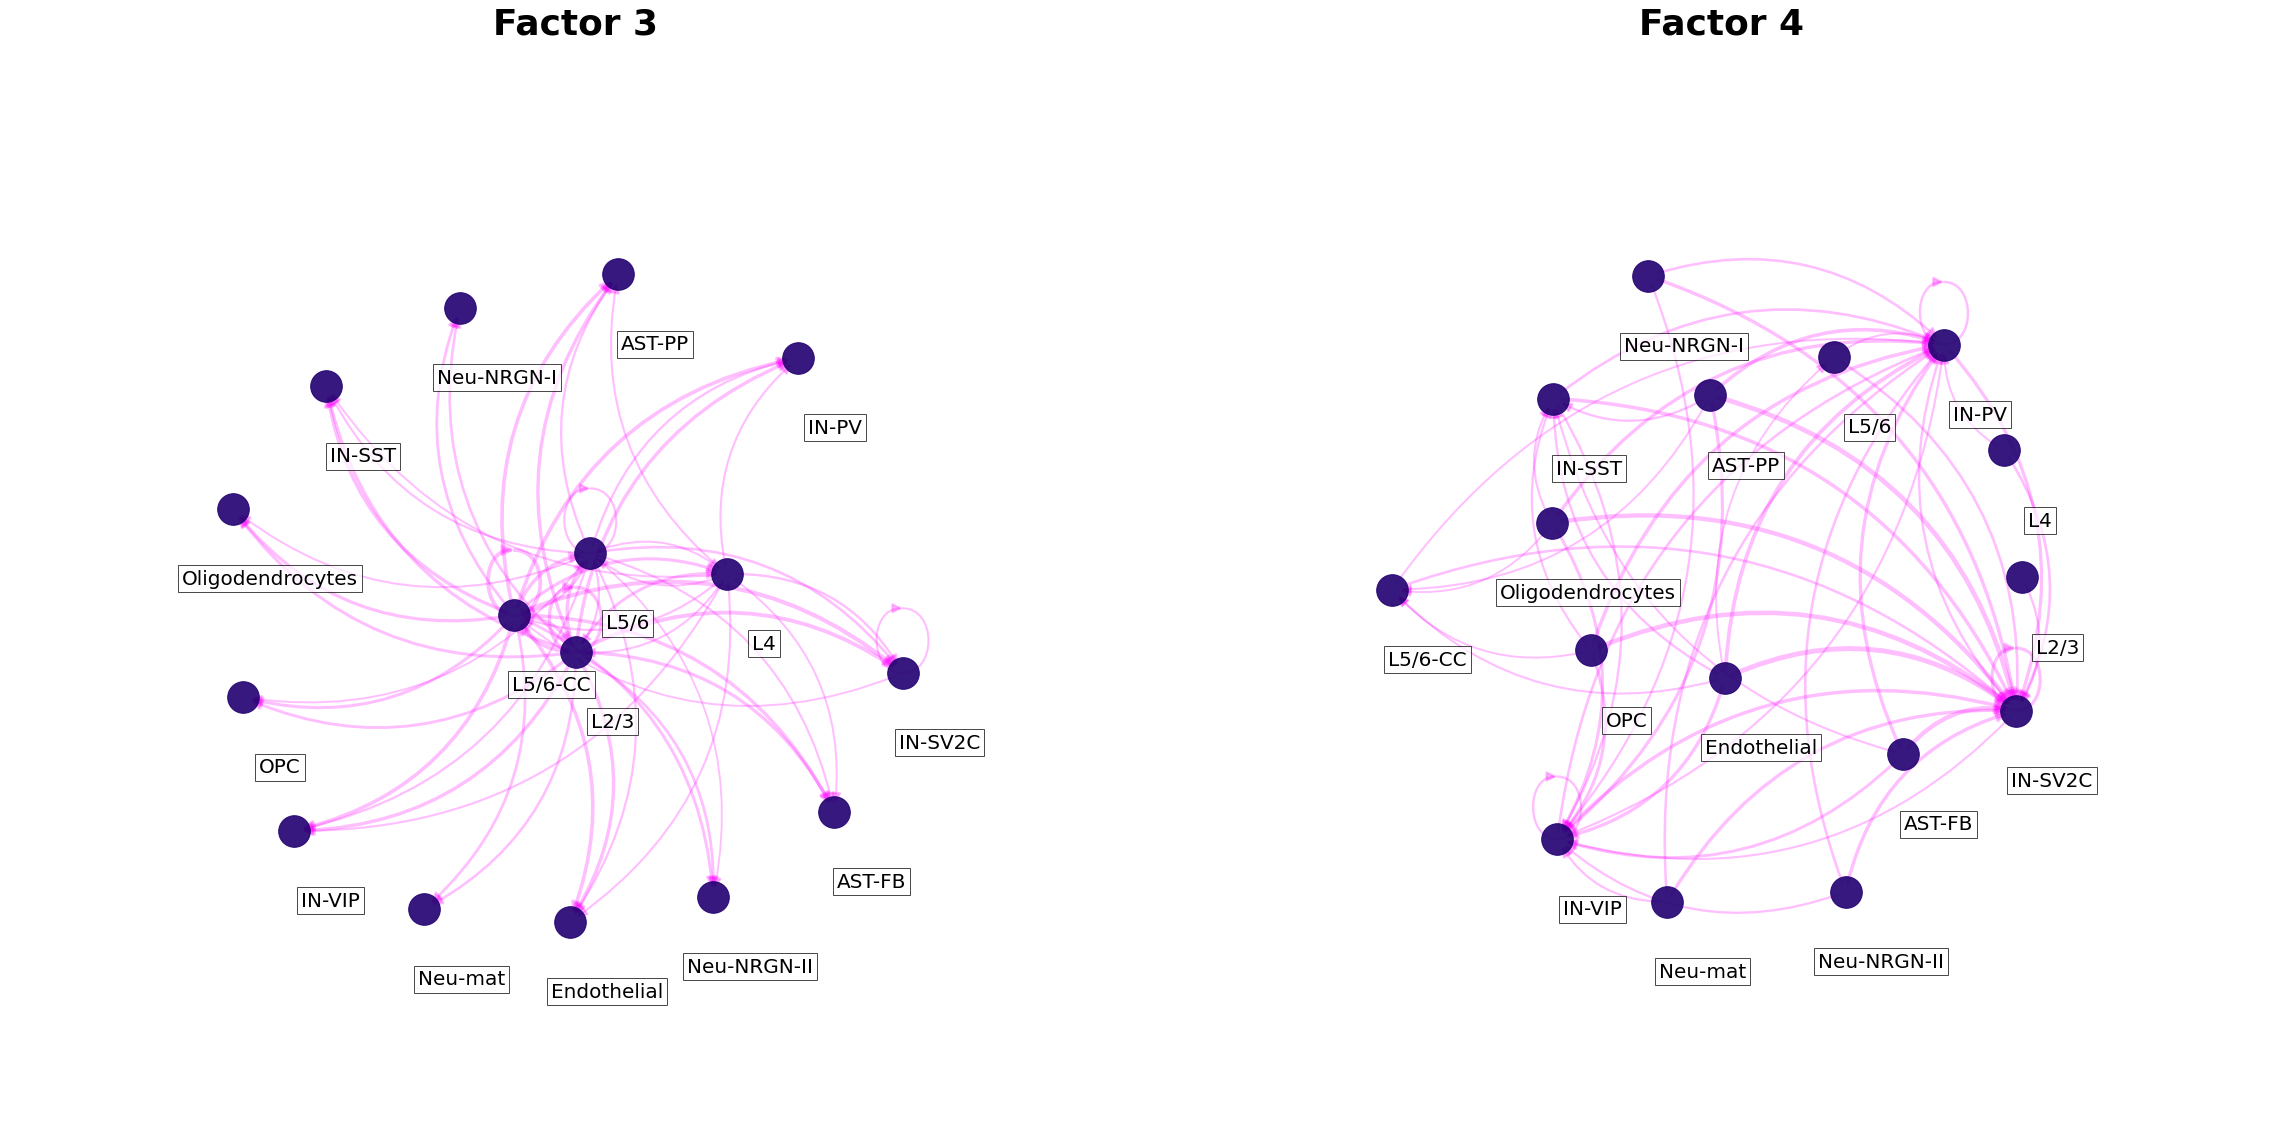

In [11]:
c2c.plotting.ccc_networks_plot(factors,
                               included_factors=['Factor 3', 'Factor 4'],
                               ccc_threshold=ccc_threshold, # Only important communication
                               nrows=1,
                               panel_size=(16, 16), # This changes the size of each figure panel.
                              )

Here we see the factor-specific communication at the cell resolution. For factor 3, L5/6-CC, L5/6, and L2/3 have high centrality due to their strong sending signals, in agreement with the factor loading plots. 

### Gini coefficients of the factor-specific cell-cell communication

Gini coefficient quantifies the dispersion of the edge weights (potential of a pair of cells to communicate) in each factor-specific cell-cell communication network. Here it is use to measure the imbalance of communication. In other words, to identify whether few cells are key for the pattern found, or the pattern corresponds to a more general process that involves most of the cell types.

Higher Gini coefficients are for communication where few cell types are important. Lower values represent more general processes of communication involving most of the cell types. Gini coefficients can be any value between [0, 1]

In [12]:
c2c.analysis.tensor_downstream.compute_gini_coefficients(factors,
                                                         sender_label='Sender Cells',
                                                         receiver_label='Receiver Cells'
                                                        )

,Factor,Gini
0,Factor 1,0.258346
1,Factor 2,0.603362
2,Factor 3,0.569844
3,Factor 4,0.493098
4,Factor 5,0.664504
5,Factor 6,0.607030


Considering the loadings obtained for both sender and receiver cells obtained from the decomposition:

![tf](../figures/tf.png)

We observe that the lowest Gini coefficient was obtained by factor 1, which is consistent with its cell loadings. Both senders and receivers are more similar or homogeneous. In contrast, other factors had higher Gini coefficients, which is consistent with the fact that few cells are driving the communication (eg. endothelial cells are the only receivers involved in the communication captured by Factor 6).

### Clustermaps

**Cluster samples/contexts by their importance across factors**

While in the manuscript of Tensor-cell2cell patients are colored by properties such as condition Category and Clinical Score, here we only provide a basic example on how clustering samples. Colors could be provided by using additional data and patient's properties. A detailed guide can be found here: https://www.chrisremmel.com/post/seaborn-color-labels/

Once having a dataframe or a dictionary for coloring patients/samples, the parameter ```col_colors=None``` should be changed. Make sure to use the same sample labels as in ```factors['Contexts'].index```

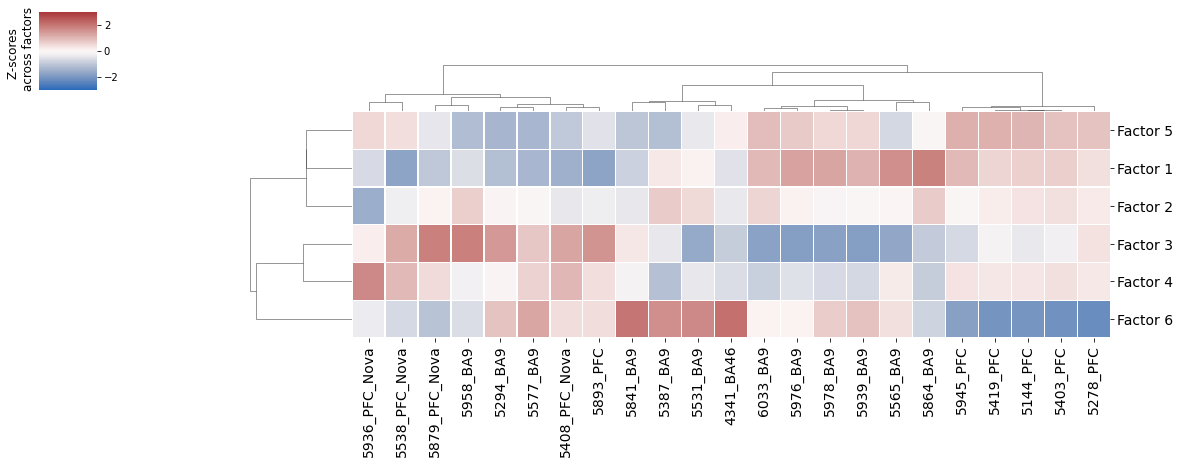

In [13]:
sample_cm = c2c.plotting.loading_clustermap(factors['Contexts'],
                                            use_zscore=True,
                                            col_colors=None, # Change this if you wanna add sample properties
                                            figsize=(16, 6),
                                            dendrogram_ratio=0.3,
                                            cbar_fontsize=12,
                                            tick_fontsize=14,
                                            filename=output_folder + 'Clustermap-Factor-specific-Contexts.svg'
                                           )

Here patients are grouped by the importance that each the communication pattern (factor) has in relation to the others, within patient. Thus, a combination of communication patterns can explain differences at the sample-specific level. [In our manuscript](https://www.biorxiv.org/content/10.1101/2021.09.20.461129v2) we showed that these clusters separate patients by ASD condition.

**Cluster LR pairs by their importance across factors**

To consider important LR pairs in at least one factor, set a loading_threshold. This value can be obtained in the way that user thinks is pertinent. Here we use ```loading_threshold=0.1```.

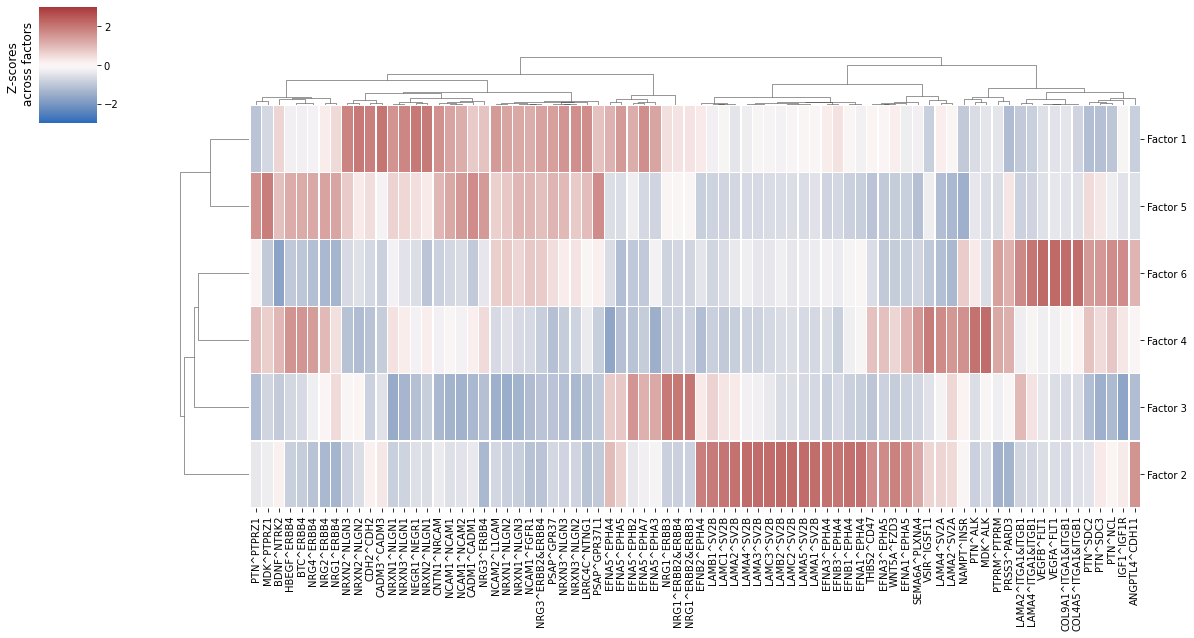

In [14]:
lr_cm = c2c.plotting.loading_clustermap(factors['Ligand-Receptor Pairs'],
                                        loading_threshold=0.1, # To consider only top LRs
                                        use_zscore=True,
                                        figsize=(16, 9),
                                        filename=output_folder + 'Clustermap-Factor-specific-LRs.svg'
                                       )

In this case, LR pairs are grouped according to how differentially important they for one factor versus the others. This can give an idea of the molecular mechanisms that are crucial in each communication pattern.